In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install mpl-scatter-density
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans
from scipy.stats import shapiro
import chart_studio as cs
from matplotlib.ticker import PercentFormatter
from scipy.stats import gaussian_kde
import mpl_scatter_density
tf.random.set_seed(42)

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

currently running tensorflow version: 2.8.0


# ML Analysis

In [25]:
# select dataset to analyze
parameterization, dataset, dataset.name, res = gl.select_dataset_coregistration(
    pth='/data/fast1/glacierml/data/',
    parameterization='sm1'
)

dataset

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0
1,63.281000,-145.427000,14.0,1162,1858,2438,17.567,172,8639,147.0
2,58.380000,-134.349000,10.0,676,1123,1494,9.528,327,6332,66.0
9,51.177000,-116.330000,15.3,2390,2526,2853,0.872,69,1181,70.0
11,44.148300,-121.773320,20.7,2321,2590,2810,0.808,91,1680,26.0
...,...,...,...,...,...,...,...,...,...,...
483,-33.403600,-69.822000,10.0,4255,5492,5885,7.233,298,8109,122.0
485,-33.222300,-70.205600,21.1,3469,4970,5364,5.374,88,4739,38.0
489,-33.029600,-70.098400,29.0,2929,5121,5894,8.376,358,8560,59.0
492,-28.381400,-69.609100,11.6,5068,5406,5753,5.209,79,3782,67.0


In [12]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
statistics = pd.DataFrame()
file_reader = pd.read_csv(rootdir + 'model_statistics_df1.csv')
statistics = pd.concat([statistics, file_reader], ignore_index = True)

statistics = statistics.drop('Unnamed: 0', axis = 1)
statistics['total parameters'] = statistics['total parameters'].astype(int)
statistics['trained parameters'] = statistics['trained parameters'].astype(int)
statistics['total inputs'] = statistics['total inputs'].astype(int)
statistics['test - train'] = (
    abs(statistics['test mae avg'] - statistics['train mae avg']))
statistics['paramater ratio'] = statistics['trained parameters'] / statistics['total inputs']
statistics

,layer architecture,total parameters,trained parameters,total inputs,test mae avg,train mae avg,test mae std dev,train mae std dev,architecture weight 1,architecture weight 2,test - train,paramater ratio
0,3-2,60,41,1719,22.765499,21.695373,3.869272,3.065704,152.806423,0.006544,1.070126,0.023851
1,4-2,72,53,1719,25.152019,23.716210,7.245143,4.836761,138.307563,0.007230,1.435809,0.030832
2,5-2,84,65,1719,22.247660,21.984060,4.608823,2.765368,156.363162,0.006395,0.263599,0.037813
3,6-2,96,77,1719,22.216797,21.965357,3.909221,2.599356,156.580376,0.006386,0.251440,0.044793
4,7-2,108,89,1719,22.958660,22.863540,3.654888,1.981141,151.520798,0.006600,0.095120,0.051774
...,...,...,...,...,...,...,...,...,...,...,...,...
156,16-15,450,431,1719,21.197862,20.917451,4.238931,3.313885,164.106856,0.006094,0.280410,0.250727
157,17-15,475,456,1719,21.969099,20.893072,4.564305,2.950295,158.345792,0.006315,1.076028,0.265271
158,18-15,500,481,1719,19.252626,18.734729,4.955883,3.593574,180.687788,0.005534,0.517897,0.279814
159,19-15,525,506,1719,21.045860,20.911683,4.048145,3.703229,165.292099,0.006050,0.134177,0.294357


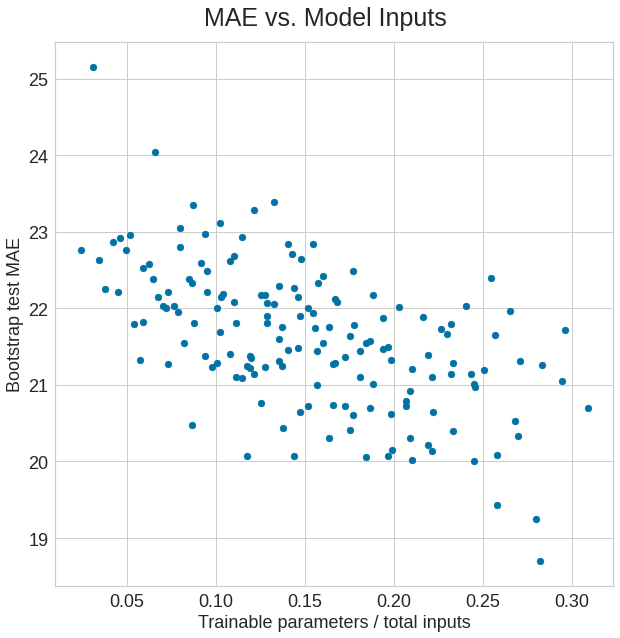

In [26]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('MAE vs. Model Inputs', fontsize = 25, y=.93
            )
fig.patch.set_facecolor('w')
plt.scatter(
    statistics['paramater ratio'],
    statistics['test mae avg']
)
# plt.xscale('log')
plt.ylabel('Bootstrap test MAE', fontsize = 18)
plt.xlabel('Trainable parameters / total inputs', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.show()
# plt.savefig('figs/MAE_vs_inputs.png')

In [14]:
parameterization

'sm3'

112
17-9


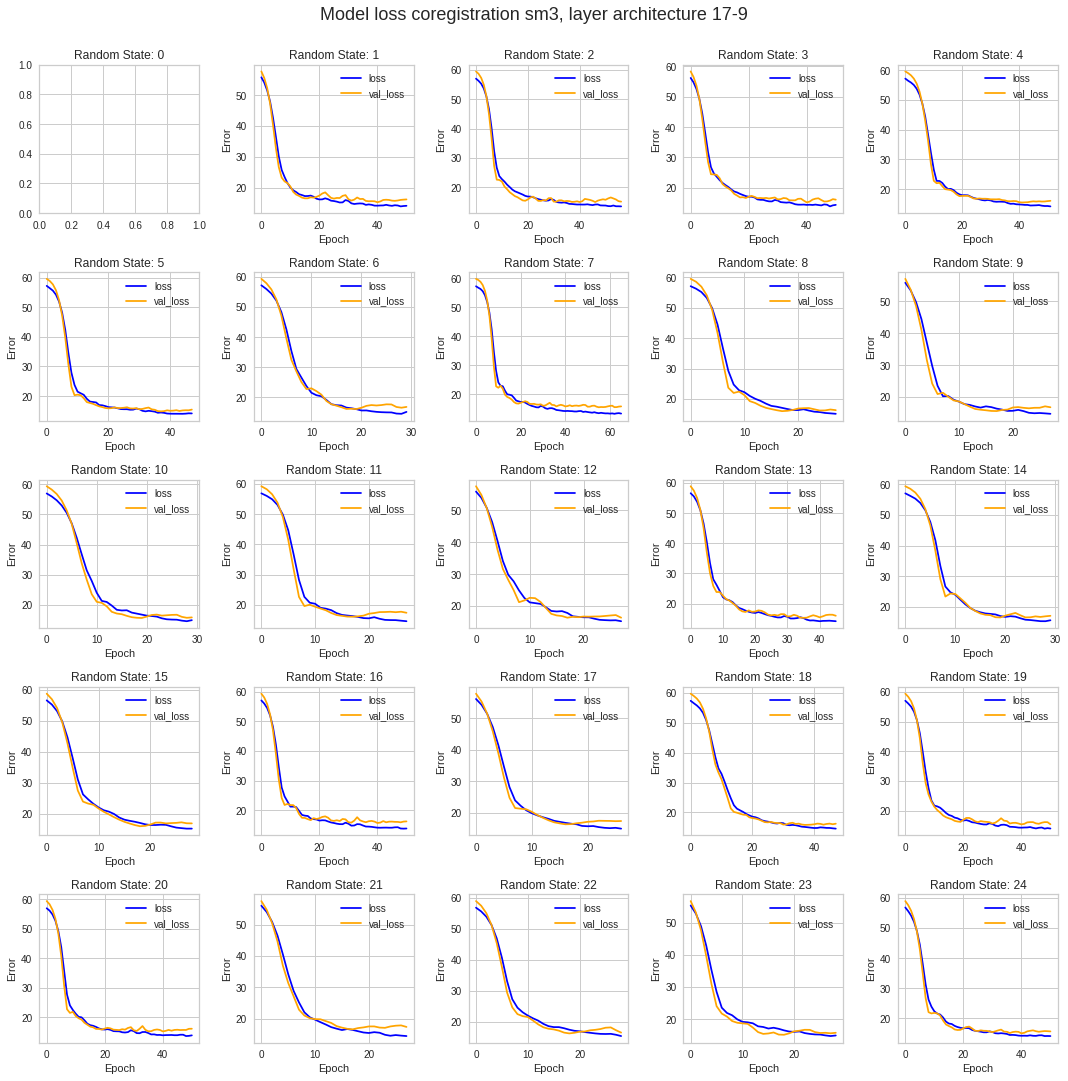

In [15]:
# load selected model and look at predicted accuracies of each random state
# print('Please select index from statistics table to inspect further')

selection = int(input())
arch = statistics['layer architecture'].loc[selection]


print(arch)

rootdir_1 = 'saved_results/' + res + '/sr_' + arch + '/'
# print(rootdir_1)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
plt.suptitle(
    'Model loss coregistration ' + parameterization +
    ', layer architecture ' + arch , fontsize=18, y=1
            )


for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (

        str(rs)
    )

    model_name = (

        str(rs)
    )

    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_name)

    ax.set_title('Random State: ' + str(rs))
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
        gl.plot_loss(dnn_history[model_name])
plt.tight_layout()

25it [00:07,  3.18it/s]


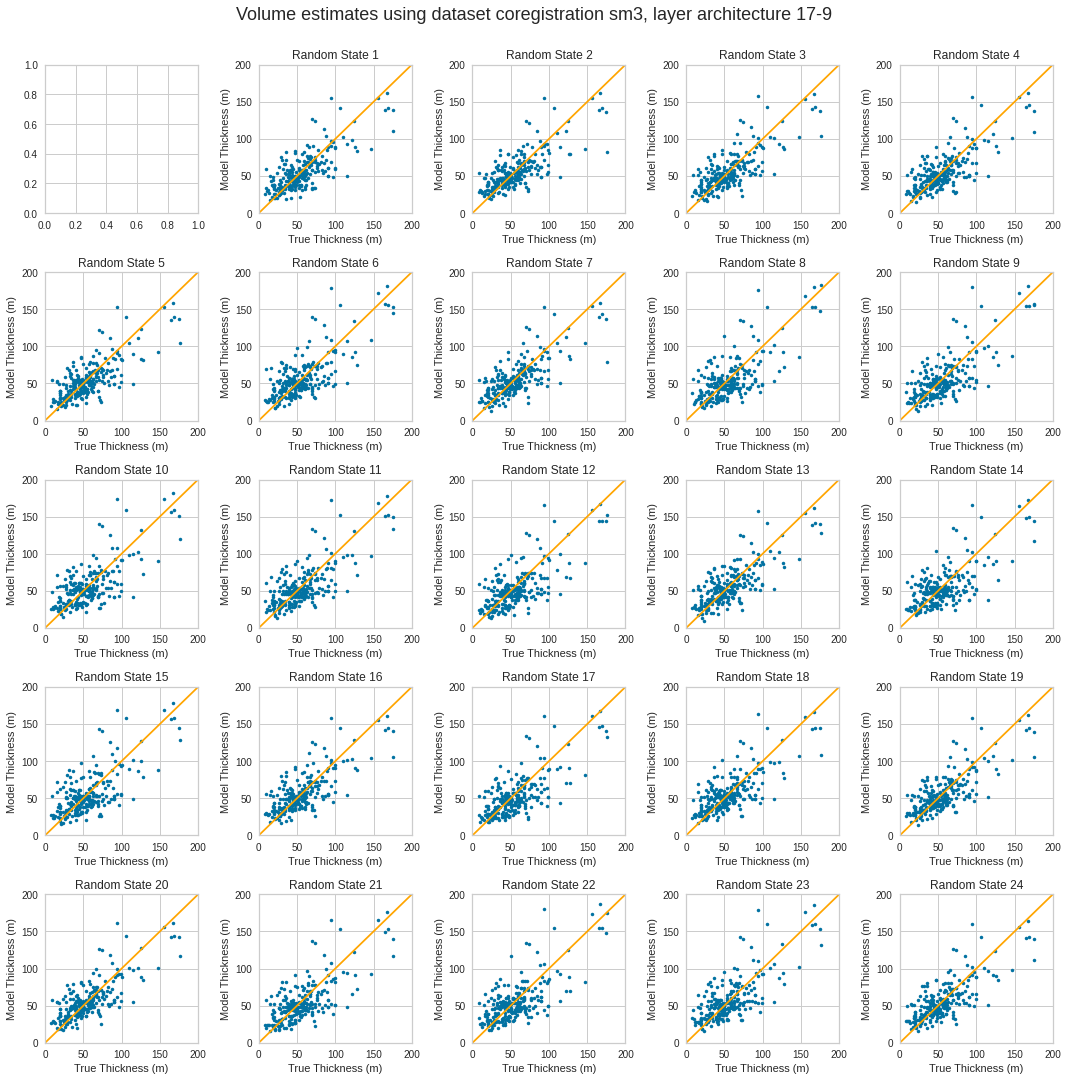

In [16]:

dnn_model = {}
rootdir_2 = 'saved_models/' + parameterization + '/sm_' + arch + '/'

train_features, test_features, train_labels, test_labels = gl.split_data(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume estimates using dataset coregistration ' + parameterization +
    ', layer architecture ' + arch , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

estimates = pd.DataFrame()

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(rs)
    )   

    model_history = (
        str(rs)
    )  

    model_path = (
        rootdir_2 + 
        str(rs)
    )

    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)

    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:

        y = dnn_model[model_name].predict(features, verbose = 0)
        plt.plot(labels,y,'.')
        plt.plot(
            (0,400),
            (0,400),
            '-',
            color = 'orange'    
        )
        plt.xlabel('True Thickness (m)')
        plt.ylabel('Model Thickness (m)')
        ax.set_title('Random State ' +str(rs))
        plt.xlim((0,200))
        plt.ylim((0,200))
        estimates = estimates.append(pd.Series(y.flatten(), name = rs))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of Model Residuals')

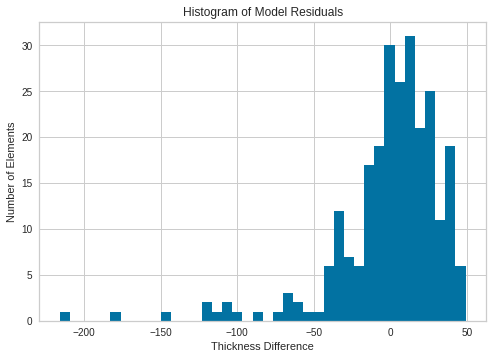

In [17]:
plt.hist(estimates.mean().mean() - labels, 40)
plt.xlabel('Thickness Difference')
plt.ylabel('Number of Elements')
plt.title('Histogram of Model Residuals')

In [2]:
architectures = gl.list_architectures(coregistration = 'df3')

100%|██████████| 7168/7168 [00:54<00:00, 132.55it/s]  


In [3]:
architectures

,architecture,coregistration
0,12-2,df3
6,13-2,df3
8,8-2,df3
27,9-2,df3
46,10-2,df3
65,11-2,df3
97,3-2,df3
116,4-2,df3
135,5-2,df3
154,6-2,df3


In [4]:
architectures['architecture'].unique()

array(['12-2', '13-2', '8-2', '9-2', '10-2', '11-2', '3-2', '4-2', '5-2',
       '6-2', '7-2', '18-2', '19-2', '7-3', '14-2', '15-2', '16-2',
       '17-2', '20-2', '4-3', '5-3', '6-3', '12-3', '13-3', '8-3', '9-3',
       '10-3', '11-3', '18-3', '19-3', '8-4', '9-4', '14-3', '15-3',
       '16-3', '17-3', '20-3', '5-4', '6-4', '7-4', '14-4', '15-4',
       '20-4', '6-5', '7-5', '8-5', '10-4', '11-4', '12-4', '13-4',
       '16-4', '17-4', '18-4', '19-4'], dtype=object)

In [18]:
for arch in tqdm(architectures['architecture'].unique()):
    dnn_model = {}
    rootdir_2 = 'saved_models/' + parameterization + '/sm_' + arch + '/'

    train_features, test_features, train_labels, test_labels = gl.split_data(dataset)
    features = pd.concat([train_features, test_features], ignore_index = True)
    labels = pd.concat([train_labels, test_labels], ignore_index = True)

    estimates = pd.DataFrame()

    for n, rs in (enumerate(RS)):
#         ax = plt.subplot(5, 5, n + 1)
        model_name = (
            str(rs)
        )   

        model_history = (
            str(rs)
        )  

        model_path = (
            rootdir_2 + 
            str(rs)
        )

        dnn_model[model_name] = tf.keras.models.load_model(model_path)
        dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)

        if abs((
            dnn_history[model_name]['loss'].iloc[-1]
        ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
            pass
        else:

            y = dnn_model[model_name].predict(features, verbose = 0)

            estimates = estimates.append(pd.Series(y.flatten(), name = rs))
    # plt.tight_layout()
    # plt.show()

100%|██████████| 54/54 [06:56<00:00,  7.72s/it]


Text(0.5, 1.0, 'Histogram of Model Residuals')

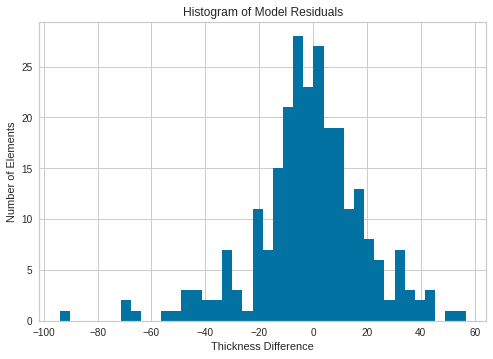

In [24]:
plt.hist(estimates.mean() - labels, 40)
plt.xlabel('Thickness Difference')
plt.ylabel('Number of Elements')
plt.title('Histogram of Model Residuals')

In [21]:
estimates.mean()

0      41.498089
1      52.719604
2      53.959217
3      42.897526
4      26.581100
         ...    
249    52.298717
250    78.736580
251    41.241993
252    29.967936
253    32.575863
Length: 254, dtype: float32

In [23]:
len(y)

254

In [ ]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
inputs = len(dataset.columns) - 1
print('total inputs = ' + str(total_inputs))
print('1/10 inputs = ' + str(0.1 * total_inputs))
print('1/2 inputs = ' + str(0.5 * total_inputs))
non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 4
layer_2 = 4


total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))